# Search Algorithms

In [1]:
import os
from overrides import overrides
from typing import List
import torch
from torch import nn
import numpy as np
import json
from random import Random

from archai.discrete_search.api import ArchaiModel, EvolutionarySearchSpace, BayesOptSearchSpace

1680142434.3962104

We will re-use the CNN search space created in the [search space example](./search_space.ipynb).

In [2]:
from model import MyModel
from cnn_search_space import CNNSearchSpaceExt as CNNSearchSpace

In [3]:
ss = CNNSearchSpace(max_layers=10, kernel_list=[3, 5, 7], hidden_list=[16, 32, 64])

In [4]:
m = ss.random_sample()
m

ArchaiModel(
	archid=L=3, K=7, H=16, 
	metadata={}, 
	arch=MyModel(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
)

## Dataset Provider

Datasets are represented in Archai throught the [`DatasetProvider`](../../reference/api/archai.discrete_search.api.rst) class. For this example, we will use the built-in dataset provider of the MNIST dataset.

In [5]:
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider

In [6]:
dataset_provider = MnistDatasetProvider()

We can get train/test PyTorch datasets from a DatasetProvider by calling `dataset_provider.get_datasets(load_train, load_test, transforms_train, transforms_test)`

In [7]:
# Loads only the training set
tr_d = dataset_provider.get_train_dataset()

## Wrapping custom evaluation code

We will evaluate the models using partial training validation accuracy as a proxy for final task performance. This notebook will take about an hour to complete if you run it on a Intel Core i9 CPU.  If you have CUDA enabled version of pytorch installed, it will be about 30 minutes if you pass the `device` argument `cuda` in the following `PartialTrainingValAccuracy` constructor.

In [8]:
from archai.api.dataset_provider import DatasetProvider
from archai.discrete_search.api import ModelEvaluator
from archai.discrete_search.evaluators import RayParallelEvaluator

from tqdm import tqdm
import math


class PartialTrainingValAccuracy(ModelEvaluator):
    def __init__(self, dataset: DatasetProvider, training_epochs: float = 1.0, lr: float = 1e-4, device: str = 'cpu',
                 progress_bar: bool = False):
        self.training_epochs = training_epochs
        self.dataset_provider = dataset
        self.device = device
        self.lr = lr
        self.progress_bar = progress_bar
    
    @overrides
    def evaluate(self, model, budget = None) -> float:
        # Loads the dataset
        tr_data = self.dataset_provider.get_train_dataset()
        val_data = self.dataset_provider.get_val_dataset()
        
        tr_dl = torch.utils.data.DataLoader(tr_data, batch_size=16, shuffle=True, num_workers=4)
        val_dl = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
        
        # Training settings
        optimizer = torch.optim.Adam(model.arch.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        model.arch.train()
        model.arch.to(self.device)
        
        # Partial training
        epoch_iter = range(math.ceil(self.training_epochs))
        if self.progress_bar:
            epoch_iter = tqdm(epoch_iter, desc=f'Training model {model.archid}')

        for epoch_nb in epoch_iter:
            # Early stops for fractional values of training epochs (e.g, 0.2)
            early_stop = len(tr_dl) + 1
            if 0 < (self.training_epochs - epoch_nb) < 1:
                early_stop = int((self.training_epochs - epoch_nb) * len(tr_dl))
            
            for i, (x, y) in enumerate(tr_dl):
                if i >= early_stop:
                    break
                
                optimizer.zero_grad()
                
                pred = model.arch(x.to(self.device))
                loss = criterion(pred, y.to(self.device))

                loss.backward()
                optimizer.step()
        
        # Evaluates final model
        model.arch.eval()
        
        with torch.no_grad():
            val_pred, val_target = [], []

            for x, y in val_dl:
                val_pred.append(model.arch(x.to(self.device)).argmax(axis=1).to('cpu'))
                val_target.append(y.to('cpu'))

            val_pred, val_target = torch.cat(val_pred, axis=0), torch.cat(val_target, axis=0)
            val_acc = (val_pred.squeeze() == val_target.squeeze()).numpy().mean()

        # Returns model to cpu
        model.arch.cpu()
        
        return val_acc

Let's test our evaluator:

In [9]:
partial_tr = PartialTrainingValAccuracy(
    dataset_provider,
    training_epochs=0.001, # Trains for 1/1000 of an epoch
    progress_bar=True
)

This evaluation is pretty quick, even on a CPU, at around 10 seconds on an Intel Core i9 processor.

In [10]:
partial_tr.evaluate(ss.random_sample())

Training model L=5, K=3, H=32: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


0.1009

We can make this objective more efficient evaluating multiple architectures in parallel. To do that, we can use the `RayParallelObjective` wrapper mentioned in the [previous example](./evaluators.ipynb):

In [11]:
# NBVAL_SKIP
parallel_partial_tr = RayParallelEvaluator(partial_tr)

Let's test our partial training objective sending two random architectures

In [12]:
# NBVAL_SKIP
parallel_partial_tr.send(ss.random_sample())
parallel_partial_tr.send(ss.random_sample())

2023-03-29 19:14:10,446	INFO worker.py:1538 -- Started a local Ray instance.


In [13]:
# NBVAL_SKIP
parallel_partial_tr.fetch_all()

Training model L=8, K=5, H=64: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


[0.1135, 0.0892]

To run the same objective distributing jobs across multiple GPUs, just set the `num_gpus` parameter from [ray.init](https://docs.ray.io/en/latest/ray-core/package-ref.html#ray-init) and set `device='cuda'` (This assumes you have installed the NVidia CUDA SDK and PyTorch for CUDA as per the setup instructions at https://pytorch.org/get-started/locally/)

```python
RayParallelObjective(
    PartialTrainingValAccuracy(training_epochs=1, device='cuda'),
    num_gpus=0.5, # 2 jobs per gpu available
    max_calls=1
)
```

## Defining Search Objectives

Search optimization objectives are specified using the `archai.discrete_search.SearchObjectives` class

In [14]:
from archai.discrete_search.api import SearchObjectives

objectives = SearchObjectives()

### Adding objectives

To add search objectives, we can use the `SearchObjectives.add_objective` method


In [15]:
from archai.discrete_search.evaluators import AvgOnnxLatency, TorchFlops

objectives.add_objective(
    # Objective function name (will be used in plots and reports)
    name='ONNX Latency (ms)',  
    
    # ModelEvaluator object that will be used to evaluate the model
    model_evaluator=AvgOnnxLatency(input_shape=(1, 1, 28, 28), num_trials=3),  
    
    # Optimization direction, `True` for maximization or `False` for minimization
    higher_is_better=False,

    # Whether this objective should be considered 'compute intensive' or not.
    compute_intensive=False 
)


The `compute_intensive` flag is used in some search algorithms to help increase search efficiency. For instance, search algorithms that use surrogate models may try to estimate the value of expensive objective functions of unseen architectures in certain situations, while cheap objectives (`compute_intensive=False`) will just be computed directly.

In [16]:
objectives.add_objective(
    'FLOPs', TorchFlops(torch.randn(1, 1, 28, 28)),
    higher_is_better=False,
    compute_intensive=False,
    # We may optionally add a constraint. 
    # Architectures outside this range will be ignored by the search algorithm
    constraint=(0.0, 1e9)
)

Additionally, objectives that are cheap to evaluate (`compute_intensive=False`) may receive an optional `constraint` argument. Model candidates outside this range will
be ignored by the search algorithm.

We can evaluate cheap objectives calling `SearchObjectives.eval_cheap_objs(model_list)`

In [17]:
samples = [ss.random_sample() for _ in range(2)]
objectives.eval_cheap_objs(samples,
                           progress_bar=True)

Calculating "FLOPs"...: 100%|██████████| 2/2 [00:00<00:00, 23.84it/s]
Gathering results from async objectives...: 0it [00:00, ?it/s]


{'ONNX Latency (ms)': array([0.00050963, 0.0002865 ]),
 'FLOPs': array([1.02434954e+08, 1.19607370e+08])}

We can check if a model satisfies the constraints we added for the FLOPs objective by calling `SearchObjectives.validate_constraints(model_list)` or `SearchObjectives.is_model_valid(ss.random_sample())`

In [18]:
m = ss.random_sample()

objectives.validate_constraints([m])

({'FLOPs': array([1.1281083e+09])}, array([], dtype=int64))

In [19]:
objectives.is_model_valid(m)

False

By default, all objective and constraints evaluations are cached to prevent spending resources in the same architecture twice.

In [20]:
# The evaluation cache is built using the
# tuple (obj_name, archid, budget)
objectives.lookup_cache('FLOPs', samples[0].archid, None)

102434954

Caching can be disabled setting `SearchObjectives(cache_objective_evaluation=False)`.

Now, let's try adding the partial training objective we created before. 

<div class="alert alert-block alert-warning">
The code below requests a GPU compatible with CUDA. If running on CPU, that's ok, it will just fall back to CPU training.
</div>

In [21]:
objectives.add_objective(
    'Partial training Validation Accuracy (1 epoch)',
    RayParallelEvaluator(
        PartialTrainingValAccuracy(dataset_provider, training_epochs=1, device='cuda'),
        num_gpus=0.5, # 2 jobs per gpu available
        max_calls=1
    ),
    higher_is_better=True,
    compute_intensive=True # This is a compute intensive evaluator
)

Expensive objectives can be evaluated using `SearchObjectives.eval_expensive_objs(model_list)`

Alternatively, all objectives (expensive and cheap) can also be evaluated using `SearchObjectives.eval_all_objs`.

### Adding extra constraints

Besides the constraint parameter from cheap objectives, it is also possible to add extra constraints that are not search objectives (and thus should not be optimized by NAS algorithms).

In [22]:
from archai.discrete_search.evaluators import TorchNumParameters

objectives.add_constraint(
    'Number of parameters',
    TorchNumParameters(),
    constraint=(0.0, 1e6)
)

In [23]:
objectives.validate_constraints([m])

({'Number of parameters': array([720586.]), 'FLOPs': array([1.1281083e+09])},
 array([], dtype=int64))

In [24]:
objectives.is_model_valid(m)

False

## Using a search algorithm

Now that we know how to create and use search objectives, we can finally use a search algorithm do to Neural Architecture Search!

### Example: `EvolutionParetoSearch`

Let's start with an evolutionary-based search algorithm

In [25]:
from archai.discrete_search.algos import EvolutionParetoSearch

In [26]:
algo = EvolutionParetoSearch(
    ss, objectives, 
    output_dir='./out_evo',
    num_iters=5, num_crossovers=5,
    mutations_per_parent=2,
    max_unseen_population=10,
    save_pareto_model_weights=False,
    seed=42
)

In [27]:
# NBVAL_SKIP
search_results = algo.search()

2023-03-29 19:16:04,354 - archai.discrete_search.algos.evolution_pareto — INFO —  Using 10 random architectures as the initial population ...
2023-03-29 19:16:04,536 - archai.discrete_search.algos.evolution_pareto — INFO —  Iteration 1/5
2023-03-29 19:16:04,537 - archai.discrete_search.algos.evolution_pareto — INFO —  Calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models ...
2023-03-29 19:19:42,179 - archai.discrete_search.algos.evolution_pareto — INFO —  Updating Pareto frontier ...
2023-03-29 19:19:42,180 - archai.discrete_search.algos.evolution_pareto — INFO —  Found 7 members.
2023-03-29 19:19:42,651 - archai.discrete_search.algos.evolution_pareto — INFO —  Optimzing memory usage ...
2023-03-29 19:19:42,652 - archai.discrete_search.algos.evolution_pareto — INFO —  Choosing 7 parents ...


Mutating parents: 100%|██████████| 7/7 [00:00<00:00, 52.68it/s]

2023-03-29 19:19:42,788 - archai.discrete_search.algos.evolution_pareto — INFO —  Mutation: 12 new models.
2023-03-29 19:19:42,794 - archai.discrete_search.algos.evolution_pareto — INFO —  Crossover: 1 new models.
2023-03-29 19:19:42,841 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population: 18.


2023-03-29 19:19:42,841 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population after `max_unseen_population` restriction: 10.
2023-03-29 19:19:42,841 - archai.discrete_search.algos.evolution_pareto — INFO —  Iteration 2/5
2023-03-29 19:19:42,841 - archai.discrete_search.algos.evolution_pareto — INFO —  Calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models ...
2023-03-29 19:24:37,502 - archai.discrete_search.algos.evolution_pareto — INFO —  Updating Pareto frontier ...
2023-03-29 19:24:37,504 - archai.discrete_search.algos.evolution_pareto — INFO —  Found 11 members.
2023-03-29 19:24:37,870 - archai.discrete_search.algos.evolution_pareto — INFO —  Optimzing memory usage ...
2023-03-29 19:24:37,872 - archai.discrete_search.algos.evolution_pareto — INFO —  Choosing 11 parents ...


Mutating parents: 100%|██████████| 11/11 [00:00<00:00, 43.14it/s]

2023-03-29 19:24:38,129 - archai.discrete_search.algos.evolution_pareto — INFO —  Mutation: 18 new models.
2023-03-29 19:24:38,129 - archai.discrete_search.algos.evolution_pareto — INFO —  Crossover: 0 new models.


2023-03-29 19:24:38,200 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population: 23.
2023-03-29 19:24:38,200 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population after `max_unseen_population` restriction: 10.
2023-03-29 19:24:38,201 - archai.discrete_search.algos.evolution_pareto — INFO —  Iteration 3/5
2023-03-29 19:24:38,201 - archai.discrete_search.algos.evolution_pareto — INFO —  Calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models ...
2023-03-29 19:33:04,545 - archai.discrete_search.algos.evolution_pareto — INFO —  Updating Pareto frontier ...
2023-03-29 19:33:04,548 - archai.discrete_search.algos.evolution_pareto — INFO —  Found 17 members.
2023-03-29 19:33:04,960 - archai.discrete_search.algos.evolution_pareto — INFO —  Optimzing memory usage ...
2023-03-29 19:33:04,962 - archai.discrete_search.algos.evolution_pareto — INFO —  Choosing 17 parents ...


Mutating parents: 100%|██████████| 17/17 [00:00<00:00, 30.02it/s]

2023-03-29 19:33:05,532 - archai.discrete_search.algos.evolution_pareto — INFO —  Mutation: 25 new models.
2023-03-29 19:33:05,553 - archai.discrete_search.algos.evolution_pareto — INFO —  Crossover: 1 new models.
2023-03-29 19:33:05,563 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population: 31.
2023-03-29 19:33:05,563 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population after `max_unseen_population` restriction: 10.
2023-03-29 19:33:05,578 - archai.discrete_search.algos.evolution_pareto — INFO —  Iteration 4/5
2023-03-29 19:33:05,578 - archai.discrete_search.algos.evolution_pareto — INFO —  Calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models ...


2023-03-29 19:40:54,762 - archai.discrete_search.algos.evolution_pareto — INFO —  Updating Pareto frontier ...
2023-03-29 19:40:54,767 - archai.discrete_search.algos.evolution_pareto — INFO —  Found 20 members.
2023-03-29 19:40:55,187 - archai.discrete_search.algos.evolution_pareto — INFO —  Optimzing memory usage ...
2023-03-29 19:40:55,188 - archai.discrete_search.algos.evolution_pareto — INFO —  Choosing 20 parents ...


Mutating parents: 100%|██████████| 20/20 [00:00<00:00, 38.02it/s]

2023-03-29 19:40:55,716 - archai.discrete_search.algos.evolution_pareto — INFO —  Mutation: 25 new models.
2023-03-29 19:40:55,737 - archai.discrete_search.algos.evolution_pareto — INFO —  Crossover: 1 new models.
2023-03-29 19:40:55,749 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population: 31.


2023-03-29 19:40:55,750 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population after `max_unseen_population` restriction: 10.
2023-03-29 19:40:55,751 - archai.discrete_search.algos.evolution_pareto — INFO —  Iteration 5/5
2023-03-29 19:40:55,751 - archai.discrete_search.algos.evolution_pareto — INFO —  Calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models ...
2023-03-29 19:46:08,378 - archai.discrete_search.algos.evolution_pareto — INFO —  Updating Pareto frontier ...
2023-03-29 19:46:08,384 - archai.discrete_search.algos.evolution_pareto — INFO —  Found 23 members.
2023-03-29 19:46:08,844 - archai.discrete_search.algos.evolution_pareto — INFO —  Optimzing memory usage ...
2023-03-29 19:46:08,844 - archai.discrete_search.algos.evolution_pareto — INFO —  Choosing 23 parents ...


Mutating parents: 100%|██████████| 23/23 [00:00<00:00, 30.64it/s]

2023-03-29 19:46:09,612 - archai.discrete_search.algos.evolution_pareto — INFO —  Mutation: 23 new models.
2023-03-29 19:46:09,632 - archai.discrete_search.algos.evolution_pareto — INFO —  Crossover: 1 new models.
2023-03-29 19:46:09,632 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population: 29.
2023-03-29 19:46:09,632 - archai.discrete_search.algos.evolution_pareto — INFO —  Total unseen population after `max_unseen_population` restriction: 10.


By default all algorithms will save the final pareto architectures `{output_dir}/pareto_models_iter_*/`, pareto evolution plots `pareto_*.png` and search state tables with all the results `{output_dir}/search_state_*.csv`

In [28]:
# NBVAL_SKIP
os.listdir('./out_evo')

['pareto_FLOPs_vs_Partial_training_Validation_Accuracy_1_epoch.png',
 'pareto_models_iter_1',
 'pareto_models_iter_2',
 'pareto_models_iter_3',
 'pareto_models_iter_4',
 'pareto_models_iter_5',
 'pareto_ONNX_Latency_ms_vs_FLOPs.png',
 'pareto_ONNX_Latency_ms_vs_Partial_training_Validation_Accuracy_1_epoch.png',
 'search_state_1.csv',
 'search_state_2.csv',
 'search_state_3.csv',
 'search_state_4.csv',
 'search_state_5.csv']

It is also possible to get information from the `search_results` object directly:

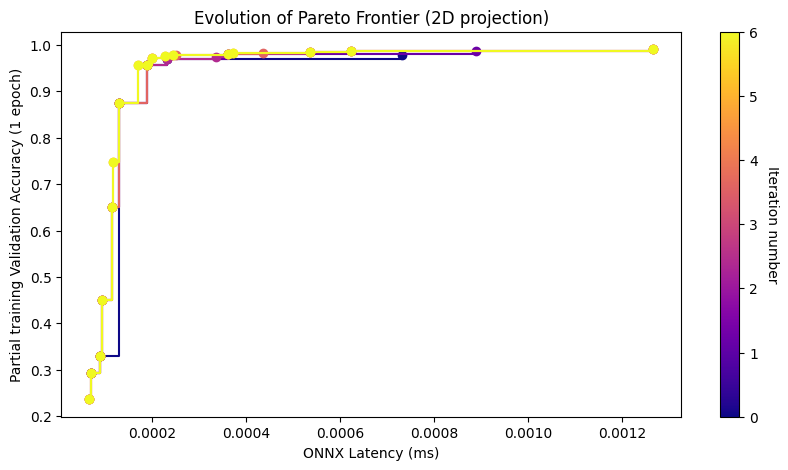

In [29]:
# NBVAL_SKIP
search_results.plot_2d_pareto_evolution(('ONNX Latency (ms)', 'Partial training Validation Accuracy (1 epoch)'))

We can get `pandas.DataFrame` object with the search results calling

In [30]:
# NBVAL_SKIP
results_df = search_results.get_search_state_df()

In [31]:
# NBVAL_SKIP
results_df.query('is_pareto').drop(columns=['is_pareto']).sort_values('Partial training Validation Accuracy (1 epoch)')

,archid,ONNX Latency (ms),FLOPs,Partial training Validation Accuracy (1 epoch),parent,parents,iteration_num,search_walltime_hours
22,"L=1, K=5, H=16",0.000067,690250.0,0.2366,"L=1, K=7, H=16",None,2,0.283439
5,"L=1, K=7, H=16",0.000071,1292362.0,0.2929,None,None,0,0.060559
36,"L=2, K=3, H=16",0.000091,3951690.0,0.3045,"L=9, K=7, H=16",None,3,0.414055
2,"L=1, K=7, H=64",0.000090,5169418.0,0.3303,None,None,0,0.060559
16,"L=2, K=5, H=16",0.000094,10775626.0,0.4510,"L=4, K=5, H=16",None,1,0.142594
13,"L=4, K=3, H=16",0.000114,11277386.0,0.6514,"L=4, K=7, H=16",None,1,0.142594
21,"L=5, K=3, H=16",0.000272,14940234.0,0.7085,"L=6, K=3, H=16",None,2,0.283439
1,"L=6, K=3, H=16",0.000133,18603082.0,0.7211,None,None,0,0.060559
41,"L=3, K=5, H=16",0.000117,20861002.0,0.7473,None,None,4,0.501170
34,"L=8, K=3, H=16",0.000153,25928778.0,0.8375,"L=4, K=3, H=16",None,3,0.414055


Since our search space is also compatible with Bayesian Optimization algorithms, let's try more sophisticated algorithm like MO-BANANAS. 

MO-BANANAS will progressively train a surrogate model based on the data gathered during search. This surrogate model will be used to predict the result of expensive objective function evaluations and will try to determine what are the best possible architectures according to the surrogate model.

In [32]:
from archai.discrete_search.algos import MoBananasSearch

In [33]:
algo2 = MoBananasSearch(
    ss, objectives, 
    output_dir='./out_bananas', 
    num_iters=5, mutations_per_parent=5,
    num_candidates=20,
    seed=43
)

In [34]:
# NBVAL_SKIP
search_results2 = algo2.search()

2023-03-29 19:46:12,111 - archai.discrete_search.algos.bananas — INFO —  Iteration 1/5
2023-03-29 19:46:12,112 - archai.discrete_search.algos.bananas — INFO —  Evaluating objectives for 10 architectures ...
2023-03-29 19:49:47,678 - archai.discrete_search.algos.bananas — INFO —  Updating surrogate model ...


Training DNN Ensemble...: 100%|██████████| 5/5 [00:33<00:00,  6.63s/it]

2023-03-29 19:50:20,852 - archai.discrete_search.algos.bananas — INFO —  Generating mutations for 10 parent architectures ...


2023-03-29 19:50:21,262 - archai.discrete_search.algos.bananas — INFO —  Found 36 new architectures satisfying constraints.
2023-03-29 19:50:21,263 - archai.discrete_search.algos.bananas — INFO —  Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model ...
2023-03-29 19:50:21,267 - archai.discrete_search.algos.bananas — INFO —  Calculating cheap objectives ['ONNX Latency (ms)', 'FLOPs'] for new architectures ...
2023-03-29 19:50:22,452 - archai.discrete_search.algos.bananas — INFO —  Best 20 candidate architectures were selected for the next iteration.
2023-03-29 19:50:22,811 - archai.discrete_search.algos.bananas — INFO —  Iteration 2/5
2023-03-29 19:50:22,812 - archai.discrete_search.algos.bananas — INFO —  Evaluating objectives for 20 architectures ...
2023-03-29 19:55:31,589 - archai.discrete_search.algos.bananas — INFO —  Updating surrogate model ...


Training DNN Ensemble...: 100%|██████████| 5/5 [00:34<00:00,  6.83s/it]

2023-03-29 19:56:05,762 - archai.discrete_search.algos.bananas — INFO —  Generating mutations for 10 parent architectures ...


2023-03-29 19:56:06,143 - archai.discrete_search.algos.bananas — INFO —  Found 28 new architectures satisfying constraints.
2023-03-29 19:56:06,143 - archai.discrete_search.algos.bananas — INFO —  Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model ...
2023-03-29 19:56:06,147 - archai.discrete_search.algos.bananas — INFO —  Calculating cheap objectives ['ONNX Latency (ms)', 'FLOPs'] for new architectures ...
2023-03-29 19:56:06,770 - archai.discrete_search.algos.bananas — INFO —  Best 20 candidate architectures were selected for the next iteration.
2023-03-29 19:56:07,170 - archai.discrete_search.algos.bananas — INFO —  Iteration 3/5
2023-03-29 19:56:07,170 - archai.discrete_search.algos.bananas — INFO —  Evaluating objectives for 20 architectures ...
2023-03-29 20:01:57,750 - archai.discrete_search.algos.bananas — INFO —  Updating surrogate model ...


Training DNN Ensemble...: 100%|██████████| 5/5 [00:31<00:00,  6.28s/it]

2023-03-29 20:02:29,188 - archai.discrete_search.algos.bananas — INFO —  Generating mutations for 10 parent architectures ...


2023-03-29 20:02:29,521 - archai.discrete_search.algos.bananas — INFO —  Found 11 new architectures satisfying constraints.
2023-03-29 20:02:29,521 - archai.discrete_search.algos.bananas — INFO —  Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model ...
2023-03-29 20:02:29,524 - archai.discrete_search.algos.bananas — INFO —  Calculating cheap objectives ['ONNX Latency (ms)', 'FLOPs'] for new architectures ...
2023-03-29 20:02:29,646 - archai.discrete_search.algos.bananas — INFO —  Best 20 candidate architectures were selected for the next iteration.
2023-03-29 20:02:30,084 - archai.discrete_search.algos.bananas — INFO —  Iteration 4/5
2023-03-29 20:02:30,084 - archai.discrete_search.algos.bananas — INFO —  Evaluating objectives for 11 architectures ...
2023-03-29 20:09:48,369 - archai.discrete_search.algos.bananas — INFO —  Updating surrogate model ...


Training DNN Ensemble...: 100%|██████████| 5/5 [00:31<00:00,  6.32s/it]

2023-03-29 20:10:19,986 - archai.discrete_search.algos.bananas — INFO —  Generating mutations for 10 parent architectures ...


2023-03-29 20:10:20,246 - archai.discrete_search.algos.bananas — INFO —  Found 5 new architectures satisfying constraints.
2023-03-29 20:10:20,247 - archai.discrete_search.algos.bananas — INFO —  Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model ...
2023-03-29 20:10:20,251 - archai.discrete_search.algos.bananas — INFO —  Calculating cheap objectives ['ONNX Latency (ms)', 'FLOPs'] for new architectures ...
2023-03-29 20:10:20,252 - archai.discrete_search.algos.bananas — INFO —  Best 20 candidate architectures were selected for the next iteration.
2023-03-29 20:10:20,720 - archai.discrete_search.algos.bananas — INFO —  Iteration 5/5
2023-03-29 20:10:20,721 - archai.discrete_search.algos.bananas — INFO —  Evaluating objectives for 5 architectures ...
2023-03-29 20:10:20,723 - archai.discrete_search.algos.bananas — INFO —  Updating surrogate model ...


Training DNN Ensemble...: 100%|██████████| 5/5 [00:33<00:00,  6.77s/it]

2023-03-29 20:10:54,613 - archai.discrete_search.algos.bananas — INFO —  Generating mutations for 10 parent architectures ...


2023-03-29 20:10:54,880 - archai.discrete_search.algos.bananas — INFO —  Found 5 new architectures satisfying constraints.
2023-03-29 20:10:54,881 - archai.discrete_search.algos.bananas — INFO —  Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model ...
2023-03-29 20:10:54,885 - archai.discrete_search.algos.bananas — INFO —  Calculating cheap objectives ['ONNX Latency (ms)', 'FLOPs'] for new architectures ...
2023-03-29 20:10:54,945 - archai.discrete_search.algos.bananas — INFO —  Best 20 candidate architectures were selected for the next iteration.


In [35]:
# NBVAL_SKIP
os.listdir('./out_bananas')

['pareto_FLOPs_vs_Partial_training_Validation_Accuracy_1_epoch.png',
 'pareto_ONNX_Latency_ms_vs_FLOPs.png',
 'pareto_ONNX_Latency_ms_vs_Partial_training_Validation_Accuracy_1_epoch.png',
 'search_state_0.csv',
 'search_state_1.csv',
 'search_state_2.csv',
 'search_state_3.csv',
 'search_state_4.csv']

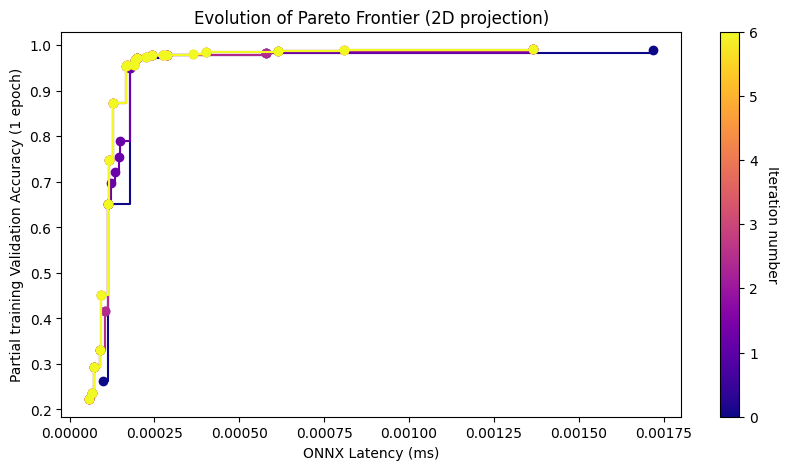

In [36]:
# NBVAL_SKIP
search_results2.plot_2d_pareto_evolution(('ONNX Latency (ms)', 'Partial training Validation Accuracy (1 epoch)'))

MO-BANANAS will also save the predictive mean and variance of the expensive objectives during that iteration .

In [37]:
# NBVAL_SKIP
results_df2 = search_results2.get_search_state_df()
results_df2.query('is_pareto').sort_values('Partial training Validation Accuracy (1 epoch)').drop(columns=['is_pareto'])

,archid,ONNX Latency (ms),FLOPs,Partial training Validation Accuracy (1 epoch),iteration_num,Predicted Partial training Validation Accuracy (1 epoch) mean,Predicted Partial training Validation Accuracy (1 epoch) var,search_walltime_hours
14,"L=1, K=3, H=16",0.000059,288842.0,0.2225,1,0.475666,0.002211,0.155478
42,"L=1, K=5, H=16",0.000067,690250.0,0.2366,2,0.245449,0.000204,0.262745
32,"L=1, K=3, H=32",0.000075,577674.0,0.2473,2,0.260814,0.000564,0.262745
34,"L=1, K=3, H=64",0.000076,1155338.0,0.2483,2,0.535216,0.015243,0.262745
22,"L=1, K=7, H=16",0.000071,1292362.0,0.2929,1,0.299682,0.002974,0.155478
46,"L=2, K=3, H=16",0.000091,3951690.0,0.3045,2,0.312893,0.000101,0.262745
15,"L=1, K=7, H=64",0.000090,5169418.0,0.3303,1,0.602266,0.005785,0.155478
20,"L=3, K=3, H=16",0.000105,7614538.0,0.4167,1,0.587572,0.000149,0.155478
55,"L=2, K=5, H=16",0.000094,10775626.0,0.4510,3,0.446544,0.000443,0.393473
5,"L=4, K=3, H=16",0.000114,11277386.0,0.6514,0,NaN,NaN,0.059947


Let's use [plotly](https://plotly.com/) to compare the final pareto frontiers of both algorithms:

In [38]:
# NBVAL_SKIP
%pip install plotly

import pandas as pd
import plotly.express as px

merged_results_df = pd.concat([
    results_df.assign(algo='Evolution Pareto'),
    results_df2.assign(algo='Mo-BANANAS')
], axis=0)

fig = px.scatter(
    merged_results_df.query('is_pareto'), 
    'ONNX Latency (ms)', 
    'Partial training Validation Accuracy (1 epoch)',
    hover_name='archid',
    color='algo',
    facet_col='algo'
)

fig.layout = fig.layout.update(showlegend=False)
fig

Note: you may need to restart the kernel to use updated packages.


You can get much faster search times using Azure ML with partial training happening in parallel across a GPU cluster.  See the [Advanced Guide, Cloud-Based, Azure, Multi node search](https://microsoft.github.io/archai/advanced_guide/cloud/azure/notebooks/multi_node_search/multi_node_search.html) example for details.

### Troubleshooting

**OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.**

This error might happen on Windows if your python environment has multiple version of this `libiomp5md.dll` in different locations, for example, one in `~\Library\bin` and another in `Lib\site-packages\torch\lib`.  To resolve this copy the newest one over the older one so that the same dll is found in both places.